In [498]:
#Importando as bibliotecas 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [499]:
df = pd.read_csv('train.csv')

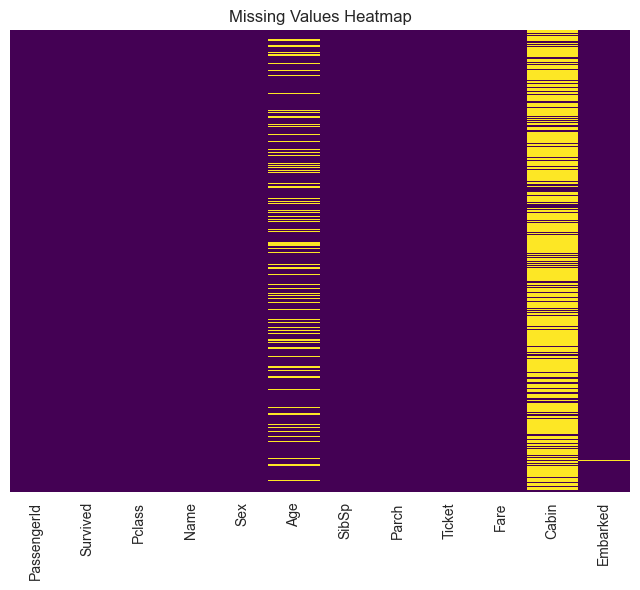

In [500]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

In [501]:
#Arredondando todas as idades para facilitar o trabalho
df['Age'] = df['Age'].round()
#Criando uma coluna nova com o titulo da pessoa
df['Title'] = df['Name'].str.extract(r'\b([A-Za-z]+)\.')
#Master = Homem muito jovem para ser chamado de de Mr
#Mrs = mulher casada
#Miss = mulher não casada
#Mr = Homem seja casado ou não
#Outro = outros titulos
valid_titles = ['Mr', 'Miss', 'Mrs', 'Master']
df['Title'] = df['Title'].replace({title: 'Outro' for title in df['Title'].unique() if title not in valid_titles})

In [502]:
#Troca os valores nulos de cada coluna pela média de seus titulos
age_mapping = {'Mr': 32, 'Miss': 22, 'Mrs': 36, 'Master': 5, 'Outro': 42}
df['Age'] = df['Age'].fillna(df['Title'].map(age_mapping))

In [503]:
#A coluna cabine 77% dos valores nulos, logo é descartavel
df = df.drop('Cabin', axis=1)

In [504]:
null_embarked_rows = df[df['Embarked'].isnull()]
print(null_embarked_rows)

     PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Embarked Title  
61   female  38.0      0      0  113572  80.0      NaN  Miss  
829  female  62.0      0      0  113572  80.0      NaN   Mrs  


In [505]:
df = df.dropna()

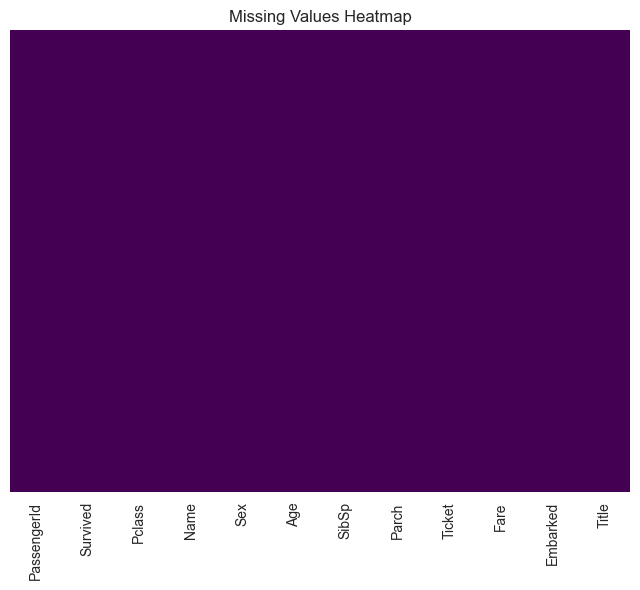

In [506]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

In [507]:
# Modelo

In [508]:
df['TicketRepetido'] = df.duplicated('Ticket', keep=False).astype(int)
df['Familia'] = ((df['SibSp'] + df['Parch']) > 0).astype(int)

title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Outro': 4}
df['Title'] = df['Title'].map(title_mapping)

embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
df['Embarked'] = df['Embarked'].map(embarked_mapping)

sex_mapping = {'male': 0, 'female': 1}
df['Sex'] = df['Sex'].map(sex_mapping)

df['Relacionados'] = ((df['TicketRepetido'] + df['Familia']) > 0).astype(int)

In [509]:
df = df.drop('Name', axis=1)
df = df.drop('Ticket', axis=1)
df = df.drop('TicketRepetido', axis=1)
df = df.drop('Familia', axis=1)

In [510]:
##Matriz de Correlação

In [511]:
dfCorrelacao = df
dfCorrelacao['Fare'] = dfCorrelacao['Fare'].apply(lambda x: 1 if x > 48 else 0)

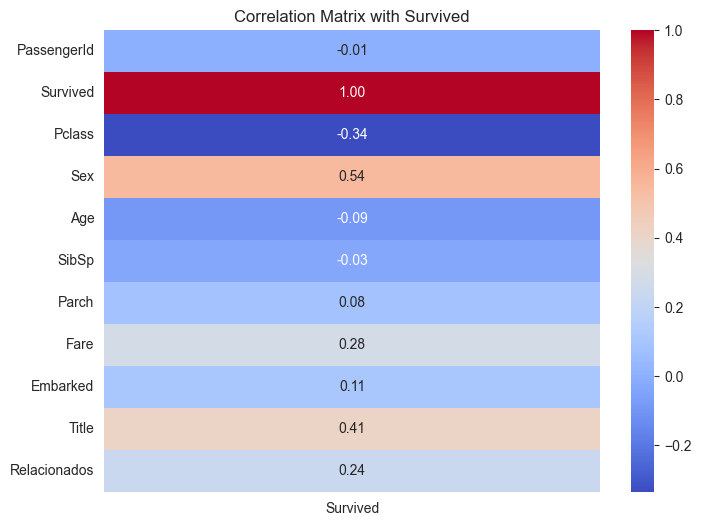

In [512]:
correlation_matrix = dfCorrelacao.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix[['Survived']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with Survived')
plt.show()
dfCorrelacao.to_csv('output.csv', index=False)

In [513]:
def odds(total, acerto):
    probabilidade = acerto / total
    odd = probabilidade/(1-probabilidade)
    return odd

In [514]:
def calculaBetai(odds1, odds2):
   divisao = odds1 / odds2
   return np.log(divisao)

In [515]:
#Intercept X = 0
def calculaIntercept(total, acerto):
    return np.log(odds(total, acerto))

In [516]:
def logistica(series,b0, b1, b2, b3, b4, b5, b6, b7):
    logit = 0
    logit += b0
    if(series.iloc[0] == 1):
        logit += b1
    if(series.iloc[2]== 2):
        logit += b2
    if(series.iloc[2] == 1):
        logit += b3
    if(series.iloc[3] == 1):
        logit += b4
    if(series.iloc[3] == 2):
        logit += b5
    if(series.iloc[3] == 3):
        logit += b6
    if(series.iloc[3] == 4):
        logit += b7
    return logit

In [517]:
def regressaoLogistica(series, b0, b1, b2, b3, b4, b5, b6, b7):
    exp = np.exp(logistica(series, b0, b1, b2, b3, b4, b5, b6, b7))
    return (exp/(1 + exp))

In [518]:
columns_to_keep = ['Sex', 'Survived', 'Pclass', 'Title', 'Age']
df = df[columns_to_keep]
print(df.columns)

Index(['Sex', 'Survived', 'Pclass', 'Title', 'Age'], dtype='object')


In [519]:
def returnB0(df):
    sobreviventes = len(df[df['Survived'] == 1])
    return calculaIntercept(len(df), sobreviventes)

In [520]:
#Sex
def returnB1(df):
    dfMulher = df[df['Sex'] == 1]
    mulherSobreviveu = len(dfMulher[dfMulher['Survived'] == 1])
    oddMulher = odds(len(dfMulher), mulherSobreviveu)
    
    dfHomem = df[df['Sex'] == 0]
    homemSobreviveu = len(dfHomem[dfHomem['Survived'] == 1])
    oddHomem = odds(len(dfHomem), homemSobreviveu)
    return calculaBetai(oddMulher, oddHomem)
    

In [521]:
def returnB2B3(df):
    dfC3 = df[df['Pclass'] == 3]
    C3Sobreviveu = len(dfC3[dfC3['Survived'] == 1])
    oddC3 = odds(len(dfC3), C3Sobreviveu)
    
    #Valor Pclass 2
    dfC2 = df[df['Pclass'] == 2]
    C2Sobreviveu = len(dfC2[dfC2['Survived'] == 1])
    oddC2 = odds(len(dfC2), C2Sobreviveu)
    
    #Valor Pclass 3
    dfC1 = df[df['Pclass'] == 1]
    C1Sobreviveu = len(dfC1[dfC1['Survived'] == 1])
    oddC1 = odds(len(dfC1), C1Sobreviveu)

    return calculaBetai(oddC2, oddC3), calculaBetai(oddC1, oddC3)

In [522]:
#title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Outro': 4}
def returnB47(df):
    dfMr = df[df['Title'] == 0]
    MrSobreviveu = len(dfMr[dfMr['Survived'] == 1])
    oddMr = odds(len(dfMr), MrSobreviveu)
    
    #Valor Miss
    dfMiss = df[df['Title'] == 1]
    MissSobreviveu = len(dfMiss[dfMiss['Survived'] == 1])
    oddMiss = odds(len(dfMiss), MissSobreviveu)
    
    #Valor Mrs
    dfMrs = df[df['Title'] == 2]
    MrsSobreviveu = len(dfMrs[dfMrs['Survived'] == 1])
    oddMrs = odds(len(dfMrs), MrsSobreviveu)
    
    #Valor Master
    dfMaster = df[df['Title'] == 3]
    MasterSobreviveu = len(dfMaster[dfMaster['Survived'] == 1])
    oddMaster = odds(len(dfMaster), MasterSobreviveu)
    
    #Valor Outro
    dfOutro = df[df['Title'] == 4]
    OutroSobreviveu = len(dfOutro[dfOutro['Survived'] == 1])
    oddOutro = odds(len(dfOutro), OutroSobreviveu)
    
    return calculaBetai(oddMiss, oddMr), calculaBetai(oddMrs, oddMr), calculaBetai(oddMaster, oddMr), calculaBetai(oddOutro, oddMr)

In [523]:
def returnDf(limite, dfTreino, dfTeste):
    b0 = returnB0(dfTreino)
    b1 = returnB1(dfTreino)
    b2, b3 = returnB2B3(dfTreino)
    b4, b5, b6, b7 = returnB47(dfTreino)  
    
    data = []
    survived = []
    
    for i in range(len(dfTeste)):
        data.append(regressaoLogistica(dfTeste.iloc[i],b0, b1, b2, b3, b4, b5, b6, b7))
        survived.append(dfTeste['Survived'].iloc[i])
    
    dfRegressao =  pd.DataFrame({'Survived': survived,
                            'Regressao': data})

    dfRegressao['Regressao'] = (dfRegressao['Regressao'] > limite).astype(int)
    return dfRegressao, b0, b1, b2, b3, b4, b5, b6, b7

In [524]:
def returnMatrizConfusao(limite, dTreino, dfTeste):
    dfRegressao, b0, b1, b2, b3, b4, b5, b6, b7 = returnDf(limite, dTreino, dfTeste)
    
    verdadeiroPositivo = 0
    falsoPositivo = 0
    falsoVerdadeiro= 0
    falsoNegativo = 0
    for i in range(len(dfRegressao)):
        real = dfRegressao['Survived'].iloc[i]
        previsao = dfRegressao['Regressao'].iloc[i] 
        if(real == 1):
            if(previsao == 1):
                verdadeiroPositivo +=1
            else:
                falsoNegativo += 1
        if(real == 0):
            if(previsao == 0):
                falsoVerdadeiro +=1
            else:
                falsoPositivo += 1
    
    #A precisão mede o quanto podemos confiar num modelo quando ele prevê que um exemplo pertence a uma determinada classe.
    precisao = verdadeiroPositivo/(verdadeiroPositivo+falsoPositivo)
    
    #todas as pessoas que ele poderia classificar como positivas, quantas ele acertou.
    recall = verdadeiroPositivo/(verdadeiroPositivo+falsoNegativo)
    
    f1_score = 2 * ((precisao*recall)/(precisao+recall))
    
    print(f'Equação = {b0:.2f} + {b1:.2f}*X1 + {b2:.2f}*X2 + {b3:.2f}*X3 + {b4:.2f}*X4 + {b5:.2f}*X5 + {b6:.2f}*X6 + {b7:.2f}*X7')
    print(f"Matriz de Confusão:")
    print(f"Verdadeiro Positivo (VP): {verdadeiroPositivo}")
    print(f"Falso Positivo (FP): {falsoPositivo}")
    print(f"Falso Verdadeiro (VN): {falsoVerdadeiro}")
    print(f"Falso Negativo (FN): {falsoNegativo}")
    print("\nMétricas:")
    print(f"Recall: {recall:.4f}")
    print(f"precisao: {precisao:.4f}")
    print(f"F1-score: {f1_score:.4f}")

In [525]:
#Com o data-frame inteiro
returnMatrizConfusao(0.9, df, df)

Equação = -0.48 + 2.51*X1 + 1.03*X2 + 1.66*X3 + 2.51*X4 + 3.01*X5 + 1.99*X6 + 1.46*X7
Matriz de Confusão:
Verdadeiro Positivo (VP): 248
Falso Positivo (FP): 88
Falso Verdadeiro (VN): 461
Falso Negativo (FN): 92

Métricas:
Recall: 0.7294
precisao: 0.7381
F1-score: 0.7337


In [526]:
def returnTrainTest(df, random_state):
    df = df.sample(frac=1, random_state=random_state)
    split_index = int(0.8 * len(df))
    df_train = df.iloc[:split_index]
    df_test = df.iloc[split_index:]
    return df_train, df_test

In [527]:
dfTrain, dfTest = returnTrainTest(df, 46)
returnMatrizConfusao(0.9, dfTrain, dfTest)

Equação = -0.43 + 2.49*X1 + 0.95*X2 + 1.56*X3 + 2.50*X4 + 3.03*X5 + 2.30*X6 + 1.38*X7
Matriz de Confusão:
Verdadeiro Positivo (VP): 47
Falso Positivo (FP): 23
Falso Verdadeiro (VN): 96
Falso Negativo (FN): 12

Métricas:
Recall: 0.7966
precisao: 0.6714
F1-score: 0.7287


In [528]:
dfTrain, dfTest = returnTrainTest(df, 87)
returnMatrizConfusao(0.9, dfTrain, dfTest)

Equação = -0.45 + 2.40*X1 + 0.99*X2 + 1.78*X3 + 2.38*X4 + 2.98*X5 + 1.91*X6 + 1.69*X7
Matriz de Confusão:
Verdadeiro Positivo (VP): 49
Falso Positivo (FP): 19
Falso Verdadeiro (VN): 96
Falso Negativo (FN): 14

Métricas:
Recall: 0.7778
precisao: 0.7206
F1-score: 0.7481


In [529]:
dfTrain, dfTest = returnTrainTest(df, 19)
returnMatrizConfusao(0.9, dfTrain, dfTest)

Equação = -0.50 + 2.46*X1 + 1.22*X2 + 1.71*X3 + 2.48*X4 + 2.92*X5 + 1.82*X6 + 1.46*X7
Matriz de Confusão:
Verdadeiro Positivo (VP): 52
Falso Positivo (FP): 14
Falso Verdadeiro (VN): 92
Falso Negativo (FN): 20

Métricas:
Recall: 0.7222
precisao: 0.7879
F1-score: 0.7536


In [530]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

selected_columns = ['Sex', 'Title', 'Pclass', 'Survived']
df_model = df[selected_columns]

label_encoder = LabelEncoder()
df_model['Sex'] = label_encoder.fit_transform(df_model['Sex'])
df_model['Title'] = label_encoder.fit_transform(df_model['Title'])

X = df_model[['Sex', 'Title', 'Pclass']]
y = df_model['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.78
F1-score: 0.7333


C:\Users\cotoq\AppData\Local\Temp\ipykernel_19440\2753186594.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Sex'] = label_encoder.fit_transform(df_model['Sex'])
C:\Users\cotoq\AppData\Local\Temp\ipykernel_19440\2753186594.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Title'] = label_encoder.fit_transform(df_model['Title'])
